# 09. 폐렴아 기다려라 !

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

## 실험환경 set-up

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [150, 150]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 24
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


## 데이터 준비하기

In [3]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [4]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [8]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [9]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [10]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [11]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (150, 150, 3)
Label:  False


In [12]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


## 데이터 시각화

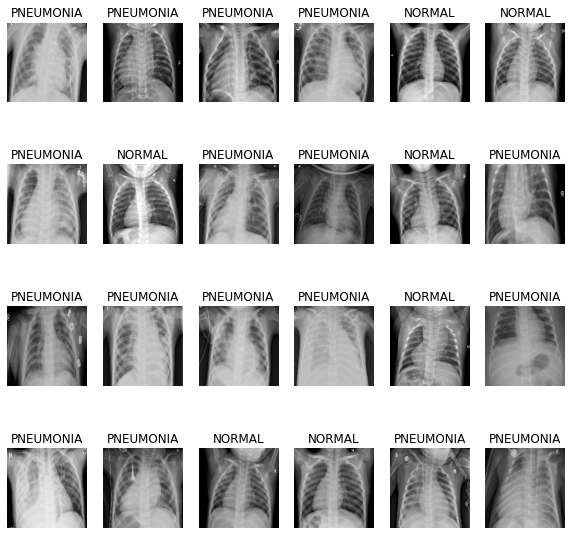

In [14]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## CNN 모델링

In [15]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [16]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
    ])
    
    return block

In [17]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(24, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(24, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        
        conv_block(256),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 데이터 imbalance처리

In [18]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


## 모델 훈련하기

In [19]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [20]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
174/174 [==============================] - 60s 275ms/step - loss: 0.2103 - accuracy: 0.9145 - precision: 0.9764 - recall: 0.9070 - val_loss: 0.6899 - val_accuracy: 0.7335 - val_precision: 0.7335 - val_recall: 1.0000
Epoch 2/10
174/174 [==============================] - 48s 276ms/step - loss: 0.1693 - accuracy: 0.9353 - precision: 0.9790 - recall: 0.9330 - val_loss: 0.9716 - val_accuracy: 0.7364 - val_precision: 0.7364 - val_recall: 1.0000
Epoch 3/10
174/174 [==============================] - 49s 281ms/step - loss: 0.1335 - accuracy: 0.9488 - precision: 0.9839 - recall: 0.9466 - val_loss: 1.1357 - val_accuracy: 0.7355 - val_precision: 0.7355 - val_recall: 1.0000
Epoch 4/10
174/174 [==============================] - 50s 286ms/step - loss: 0.1124 - accuracy: 0.9586 - precision: 0.9870 - recall: 0.9568 - val_loss: 1.1588 - val_accuracy: 0.7374 - val_precision: 0.7374 - val_recall: 1.0000
Epoch 5/10
174/174 [==============================] - 51s 297ms/step - loss: 0.1109 - accura

## 결과 확인과 시각화

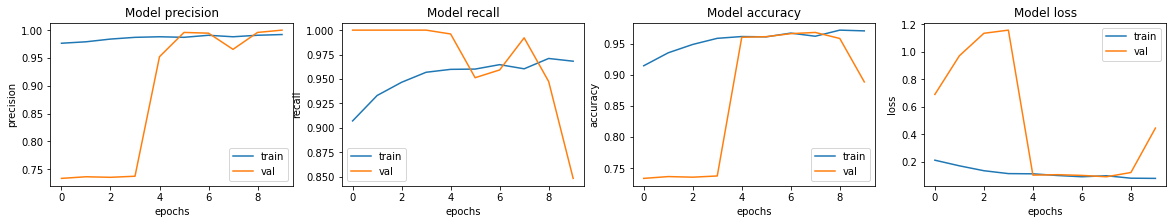

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [22]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

26/26 [==============================] - 4s 165ms/step - loss: 0.5726 - accuracy: 0.8574 - precision: 0.8592 - recall: 0.9231
Loss: 0.5725829601287842,
Accuracy: 0.8573718070983887,
Precision: 0.8591885566711426,
Recall: 0.9230769276618958


## Retrospection

<batchsize, image size 조절>
- batchsize를 16에서 24로 늘렸고 이미지 사이즈도 180에서 150으로 줄였더니 accuracy가 소폭 상승했다.

따라서 batchsize 24, image size 150으로 진행했다. 

<epoch 조절>
- epoch를 4로 설정을 했을 때 accuracy가 0.87이 나왔으나 underfitting이 우려되어 epoch를 10으로 설정했다.
- epoch를 20으로 설정 했을 때 accuracy가 0.7이 나왔다.
- epdoch를 30으로 설정 했을 때 accuracy가 0.75가 나왔다.

<batchnormalizaition, dropout 조절>
- batchnormalizaiton과 dropout을 동시에 실행 했을 때 accuracy가 0.83정도였다.
- dropout 파라미터를 0.2에서 0.5로 조절해보았다. dropout파라미터를 0.3이나 0.5로 많이 사용한다고 해서 0.5로 실행해 보았을 때 accuracy가 0.83이 나왔다.
- batchnormalizaition 없이 dropout만 갖고 진행해봤을 때 accuracy가 0.6정도로 현저히 떨어졌다
- dropout을 뺐을 때의 결과가 위의 코드 실행 결과인데 accuracy가 0.8573가 나왔다.
  dropout을 하는 이유는 overfitting을 막기 위해서 dropout을 사용하는 것으로 알고 있다.그래서 dropout을 빼고 epoch 횟수를 늘린 후 과적합을 막기 위해 early stopping을 해보고 싶었으나 코드를 실행시키는데 실패하였다.


여러가지 시도를 해보았는데 batchsize를 줄이고 image size를 줄이면 accuracy가 증가한다.  dropout파라미터도 0.5로 늘리면 accuracy증가에 도움이 된다. dropout을 사용했을 때 너무 많은 데이터를 버리게 되면 데이터 accuracy의 결과에 신빙성이 떨어지고 또 너무 많이 연결하게 되면 dropout을 사용한 의미가 없어지기 때문에 0.5가 적절한 것 같다.

batchnormalization과 dropout 중 하나만 사용해야 한다고 한다면 dropout을 없애고 batchnormalization만 사용하는 것이 accuracy를 높이는 것에 도움이 된다.  하지만 이 둘에 대한 이해가 떨어지기 때문에 공부를 더 해서 정확한 답변을 얻고 싶다.  accuracy가 0.85가 넘은 건 운이 좋았던 것 같다.

epoch에 대한 여러가지 의문점이 있는데 epoch가 accuracy에 어느정도의 영향을 미치는지 의문이다. epoch를 4로 설정한 후 결과를 본 이유는 결과를 시각화했을 때 accuracy 그래프가 떨어지는 지점을 기준으로 epoch를 설정했던 것이다. 그러나 epoch가 너무 적으면 underfitting이 되고 epoch가 너무 크면 overfitting이 되기 때문에 얼만큼이 적당한지 잘 모르겠다. 이 부분은 앞으로 epoch에 대한 이해가 더 필요해 보인다. 